In [2]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.datasets import make_classification
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
os.chdir('../')

In [4]:
from mc_hammer.cluster_measures import cvnn_sep, scatter, radial_density,dataset_midpoint_dist, dataset_meancenter_dist
from mc_hammer.cluster_measures import mean_center_dist,max_center_dist,max_diam, mean_max_diam,mean_all
from mc_hammer.similarity_functions import IGP, sillhouette_euclidean
from mc_hammer.circular_cluster_generator import generate_data
from mc_hammer.clustering_algorithms import k_means

## Functions

In [5]:
def gouss_dist(dim,seed_n):
    seed(seed_n)
    std = uniform(0.1,0.3)
    null_arr = np.array([np.random.normal(1,std,100) for i in range(dim)])
    return null_arr.T

In [6]:
def get_centers(x,labs):
    centers_list = []
    for k in range(max(labs)+1):
        one_clust = x[labs==k,:]
        center = one_clust.mean(axis = 0)
        centers_list.append(center)
    cent_array = np.array(centers_list)
    return cent_array

In [7]:
def gauss_clust_generator(k,dimx,sep,n,se,noise):
    noise_dim = int(round(dimx*noise))
    inf_dim = dimx - noise_dim
    x,labs = make_classification(
        n_samples = n,
        n_features = dimx,
        n_informative = inf_dim,
        n_redundant = noise_dim,
        n_classes = k,
        n_clusters_per_class = 1,
        class_sep = sep,
        random_state = se
    ) 
    x = x/x.max()
    centers = get_centers(x,labs)
    return x,labs,centers

In [8]:
def get_metrics_results(res_dicts,method,addit = None):
    res_list = [] 
    for i in range(len(res_dicts['x'])):
        x = res_dicts['x'][i]
        labs = res_dicts['labs'][i]
        centers = res_dicts['centers'][i]
        if method in ['mean_all','mean_max_diam','max_diam','mean_center_dist','max_center_dist']:
            res = eval(method + '(x,labs,centers)')
        elif method in ['scatter','cvnn_sep','IGP', 'sillhouette_euclidean']:
            res = eval(method + '(x,labs)')
        elif method in ['dataset_midpoint_dist', 'dataset_meancenter_dist']:
            res = eval(method + '(x,centers)')
        else:
            res = eval(method + '(x,centers,labs,addit)')
        res_list.append(res)
    return(res_list)

In [9]:
def get_k(test_string):
    test_2 = re.sub('.*k_','',test_string,)
    k = int(re.sub('_.*','',test_2))
    return k

In [10]:
def list_sorter(metric_list,method):
    if method == 'max':
        new_list = [max(i) for i in metric_list]
    elif method == 'min':
        new_list = [min(i) for i in metric_list]
    else:
        new_list = [np.mean(i) for i in metric_list]
    return new_list

In [11]:
def name_delete(x):
    x = re.sub('_dim_.*_k_[0-9]{1,2}','',x)
    x = re.sub('km_','',x)
    x = re.sub('unequal_','',x)
    x = re.sub('equal_','',x)
    x = re.sub('__','_',x)
    return(x)

In [12]:
def get_grouped(metric_dict,keys_dict):
    new_dict = {k:[] for k in keys_dict.keys()}
    for k,v in keys_dict.items():
        for i in v:
            new_dict[k].append(metric_dict[i])
    new_dict = {k:[j for i in v for j in i] for k,v in new_dict.items()}
    return new_dict

In [13]:
def get_colours(clust_var):
    if ('gauss_dis' in clust_var) or ('uni_dis' in clust_var):
        return 'gray'
    elif 'circ_clust' in clust_var:
        return 'darkviolet'
    else:
        return 'lightseagreen'

In [14]:
def make_df(dist_dict,metric):
    df_dict = {k:pd.DataFrame({
        'clust type':[k for i in range(len(v))],
        'values':v,
        'metric':[metric for i in range(len(v))]}) for k,v in dist_dict.items()}
    test_pd = pd.concat(df_dict.values())
    return test_pd

In [15]:
def std_mean(x,full_v):
    v_list = [j for i in full_v.values() for j in i]
    min_v = min(v_list)
    max_v = max(v_list)
    new_mean = np.mean([(i-min_v)/(max_v-min_v) for i in x])
    return new_mean

In [16]:
def std_mean2(x,full_v):
    v_list = [j for i in full_v.values() for j in i]
    min_v = min(v_list)
    max_v = max(v_list)
    new_mean = [(i-min_v)/(max_v-min_v) for i in x]
    return new_mean

In [17]:
def name_shorten2(x):
    x = re.sub('.*_dim','dim',x)
    x = re.sub('_sep.*','',x)
    return x

In [18]:
def mean_dif(dist_dict):
    null_list = ['uni_dis','gauss_dis']
    new_dict = {}
    for i in null_list:
        idict = {k + '_' + i:v-dist_dict[i + '_' + name_shorten2(k)] for k,v in dist_dict.items() if 'clust' in k}
        new_dict.update(idict)
    return new_dict

In [19]:
def mean_dif2(dist_dict):
    null_list = ['uni_dis','gauss_dis']
    new_dict = {}
    for i in null_list:
        idict = {k + '_' + i:[v2-np.mean(dist_dict[i + '_' + name_shorten2(k)]) for v2 in v] for k,v in dist_dict.items() if 'clust' in k}
        new_dict.update(idict)
    return new_dict

In [20]:
def one_sided_count(test_dict):
    min_count = len([i for i in test_dict if i > 0])/len(test_dict)
    return max([min_count,1-min_count])

In [21]:
def res_dict(x_list):
    return{
        'min':min(x_list),
        'max':max(x_list),
        'range':max(x_list)-min(x_list),
        'mean':abs(np.mean(x_list)),
        'one_side':one_sided_count(x_list)
    }

## Parameters

In [22]:
clusters = [2,3,4]
dim = [5,10,20]
sep = [0.5,1,3]
noise = [0,0.2,0.5]

## Uniform Distribution

In [23]:
uni_dis = {'uni_dis_dim_' +str(i):[np.random.rand(300,i) for j in range(100)] for i in dim}
uni_dis = {k+ '_k_'+str(i):{
    'x':v,
    'labs':[k_means(j,i) for j in v]} for k,v in uni_dis.items() for i in clusters}
uni_dis = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in uni_dis.items()
}

## Gaussian Distribution

In [24]:
gauss_dis = {'gauss_dis_dim_' +str(i):[np.random.rand(300,i) for j in range(100)] for i in dim}
gauss_dis = {k+ '_k_'+str(i):{
    'x':v,
    'labs':[k_means(j,i) for j in v]} for k,v in gauss_dis.items() for i in clusters}
gauss_dis = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in gauss_dis.items()
}

## Circle Clusters

In [25]:
circle_clust_equal = {'circ_clust_equal_dim_'+ str(j) + '_k_' +str(i) + '_sep_' + str(m) + '_noise_' +str(n):[generate_data(
    k = i,
    dimx = j,
    sep = m,
    n = int(round(300/i)),
    sd =np.random.uniform(0.5,3),
    se = y,
    noise = n
) for y in range(100)] for i in clusters for j in dim for m in sep for n in noise}

circle_clust_equal = {k:{
    'x':[i[0] for i in v],
    'labs':[i[1] for i in v],
    'centers':[i[2] for i in v]
} for k,v in circle_clust_equal.items()}

circle_clust_equal_km = {'km_' +k:{
    'x':v['x'],
    'labs':[k_means(i,get_k(k)) for i in v['x']]} for k,v in circle_clust_equal.items()
 }

circle_clust_equal_km = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in circle_clust_equal_km.items()
}

In [26]:
circle_clust_unequal = {'circ_clust_unequal_dim_'+ str(j) + '_k_' +str(i) + '_sep_' + str(m) + '_noise_' +str(n):[generate_data(
    k = i,
    dimx = j,
    sep = m,
    n = int(round(300/i)),
    sd =[np.random.uniform(0.5,3)for i in range(i)],
    se = y,
    noise = n
) for y in range(100)] for i in clusters for j in dim for m in sep for n in noise}

circle_clust_unequal = {k:{
    'x':[i[0] for i in v],
    'labs':[i[1] for i in v],
    'centers':[i[2] for i in v]
} for k,v in circle_clust_unequal.items()}
    
circle_clust_unequal_km = {'km_' +k:{
    'x':v['x'],
    'labs':[k_means(i,get_k(k)) for i in v['x']]} for k,v in circle_clust_unequal.items()
 }
circle_clust_unequal_km = {k:{
    'x':v['x'],
    'labs':[i[0] for i in v['labs']],
    'centers':[j[1] for j in v['labs']]} for k,v in circle_clust_unequal_km.items()
}

## Gaussian Clusters

In [27]:
gauss_clust = {'gauss_clust_dim_'+ str(j) + '_k_' +str(i) + '_sep_' + str(m) + '_noise_' +str(n):[gauss_clust_generator(
    k = i,
    dimx = j,
    sep = m,
    n = 300,
    se = y,
    noise = n
) for y in range(100)] for i in clusters for j in dim for m in sep for n in noise}
gauss_clust = {k:{
    'x':[i[0] for i in v],
    'labs':[i[1] for i in v],
    'centers':[i[2] for i in v]
} for k,v in gauss_clust.items()}

## Combine Dicts

In [28]:
full_dict = {**uni_dis,**gauss_dis,**circle_clust_equal,**circle_clust_equal_km,**circle_clust_unequal,**circle_clust_unequal_km,**gauss_clust}

## Compactness

In [29]:
compact_list = ['mean_center_dist','max_center_dist','max_diam','mean_max_diam','mean_all']
comp_dict = {i:{k:get_metrics_results(v,i) for k,v in full_dict.items()} for i in compact_list}

In [30]:
radial_list = ['single_cluster_max','single_cluster_mean','ratio']
radial_dict = {'radial_density' +i:{k:get_metrics_results(v,'radial_density',i) for k,v in full_dict.items()} for i in radial_list}

In [31]:
comp_dict = {**comp_dict,**radial_dict}

## Seperation  

In [32]:
seperation_list = ['cvnn_sep', 'scatter' ,'dataset_midpoint_dist', 'dataset_meancenter_dist']
sep_dict = {i:{k:get_metrics_results(v,i) for k,v in full_dict.items()} for i in seperation_list}

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning: invalid value encountered in double_scalars
  sep_range = [np.mean(i)/max(i) for i in sep_range]
C:\Users\nonie\Documents\mc-hammer\mc_hammer\cluster_measures.py:199: RuntimeWarning:

## Other

In [33]:
other_list = ['IGP', 'sillhouette_euclidean']
other_dict = {i:{k:get_metrics_results(v,i) for k,v in full_dict.items()} for i in other_list}

## Cleaning

In [34]:
res_dicts = {'comp':comp_dict,'sep':sep_dict,'other':other_dict}
for k,v in res_dicts.items():
    with open('data/processed/cluster_measures/'+k+'.json','w') as f:
        json.dump(v,f)

In [35]:
comp2 = comp_dict.copy()
sep2 = sep_dict.copy()
other2 = other_dict.copy()

In [36]:
dict_list = [comp2,sep2,other2]
for i in dict_list:
        test_dict = {k + '_' + j:{k2:list_sorter(v2,j) for k2,v2 in v.items() if isinstance(v2[0],list)}for k,v in i.items()for j in ['max','min','mean']}
        i.update(test_dict)

In [37]:
comp2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in comp2.items() }
sep2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in sep2.items() }
other2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in other2.items() }

In [38]:
comp2 = {k:v for k,v in comp2.items() if len(v) > 0}
sep2 = {k:v for k,v in sep2.items() if len(v) > 0}
other2 = {k:v for k,v in other2.items() if len(v) > 0 }

In [39]:
keys_list = list(full_dict.keys())
keys_list = set([name_delete(i) for i in keys_list])
keys_dict = {i:[] for i in keys_list}
for i in full_dict.keys():
    keys_dict[name_delete(i)].append(i)

In [40]:
comp2 = {k:get_grouped(v,keys_dict) for k,v in comp2.items()}
sep2 = {k:get_grouped(v,keys_dict) for k,v in sep2.items()}
other2 = {k:get_grouped(v,keys_dict) for k,v in other2.items()}

In [41]:
compdf = {k:make_df(v,k) for k,v in comp2.items()}
sepdf = {k:make_df(v,k) for k,v in sep2.items()}
otherdf = {k:make_df(v,k) for k,v in other2.items()}

In [42]:
compdf = pd.concat(compdf.values())
sepdf = pd.concat(sepdf.values())
otherdf = pd.concat(otherdf.values())

In [88]:
compdf

,clust type,values,metric
0,circ_clust_sep_0.5_noise_0.2,0.510274,radial_densityratio
1,circ_clust_sep_0.5_noise_0.2,0.506780,radial_densityratio
2,circ_clust_sep_0.5_noise_0.2,0.503367,radial_densityratio
3,circ_clust_sep_0.5_noise_0.2,0.501672,radial_densityratio
4,circ_clust_sep_0.5_noise_0.2,0.500000,radial_densityratio
...,...,...,...
895,gauss_clust_sep_1_noise_0.5,1.358287,radial_densitysingle_cluster_mean_mean
896,gauss_clust_sep_1_noise_0.5,1.456411,radial_densitysingle_cluster_mean_mean
897,gauss_clust_sep_1_noise_0.5,1.224821,radial_densitysingle_cluster_mean_mean
898,gauss_clust_sep_1_noise_0.5,1.165190,radial_densitysingle_cluster_mean_mean


## Plotting

In [44]:
palette = {i:get_colours(i) for i in compdf['clust type'].unique()}


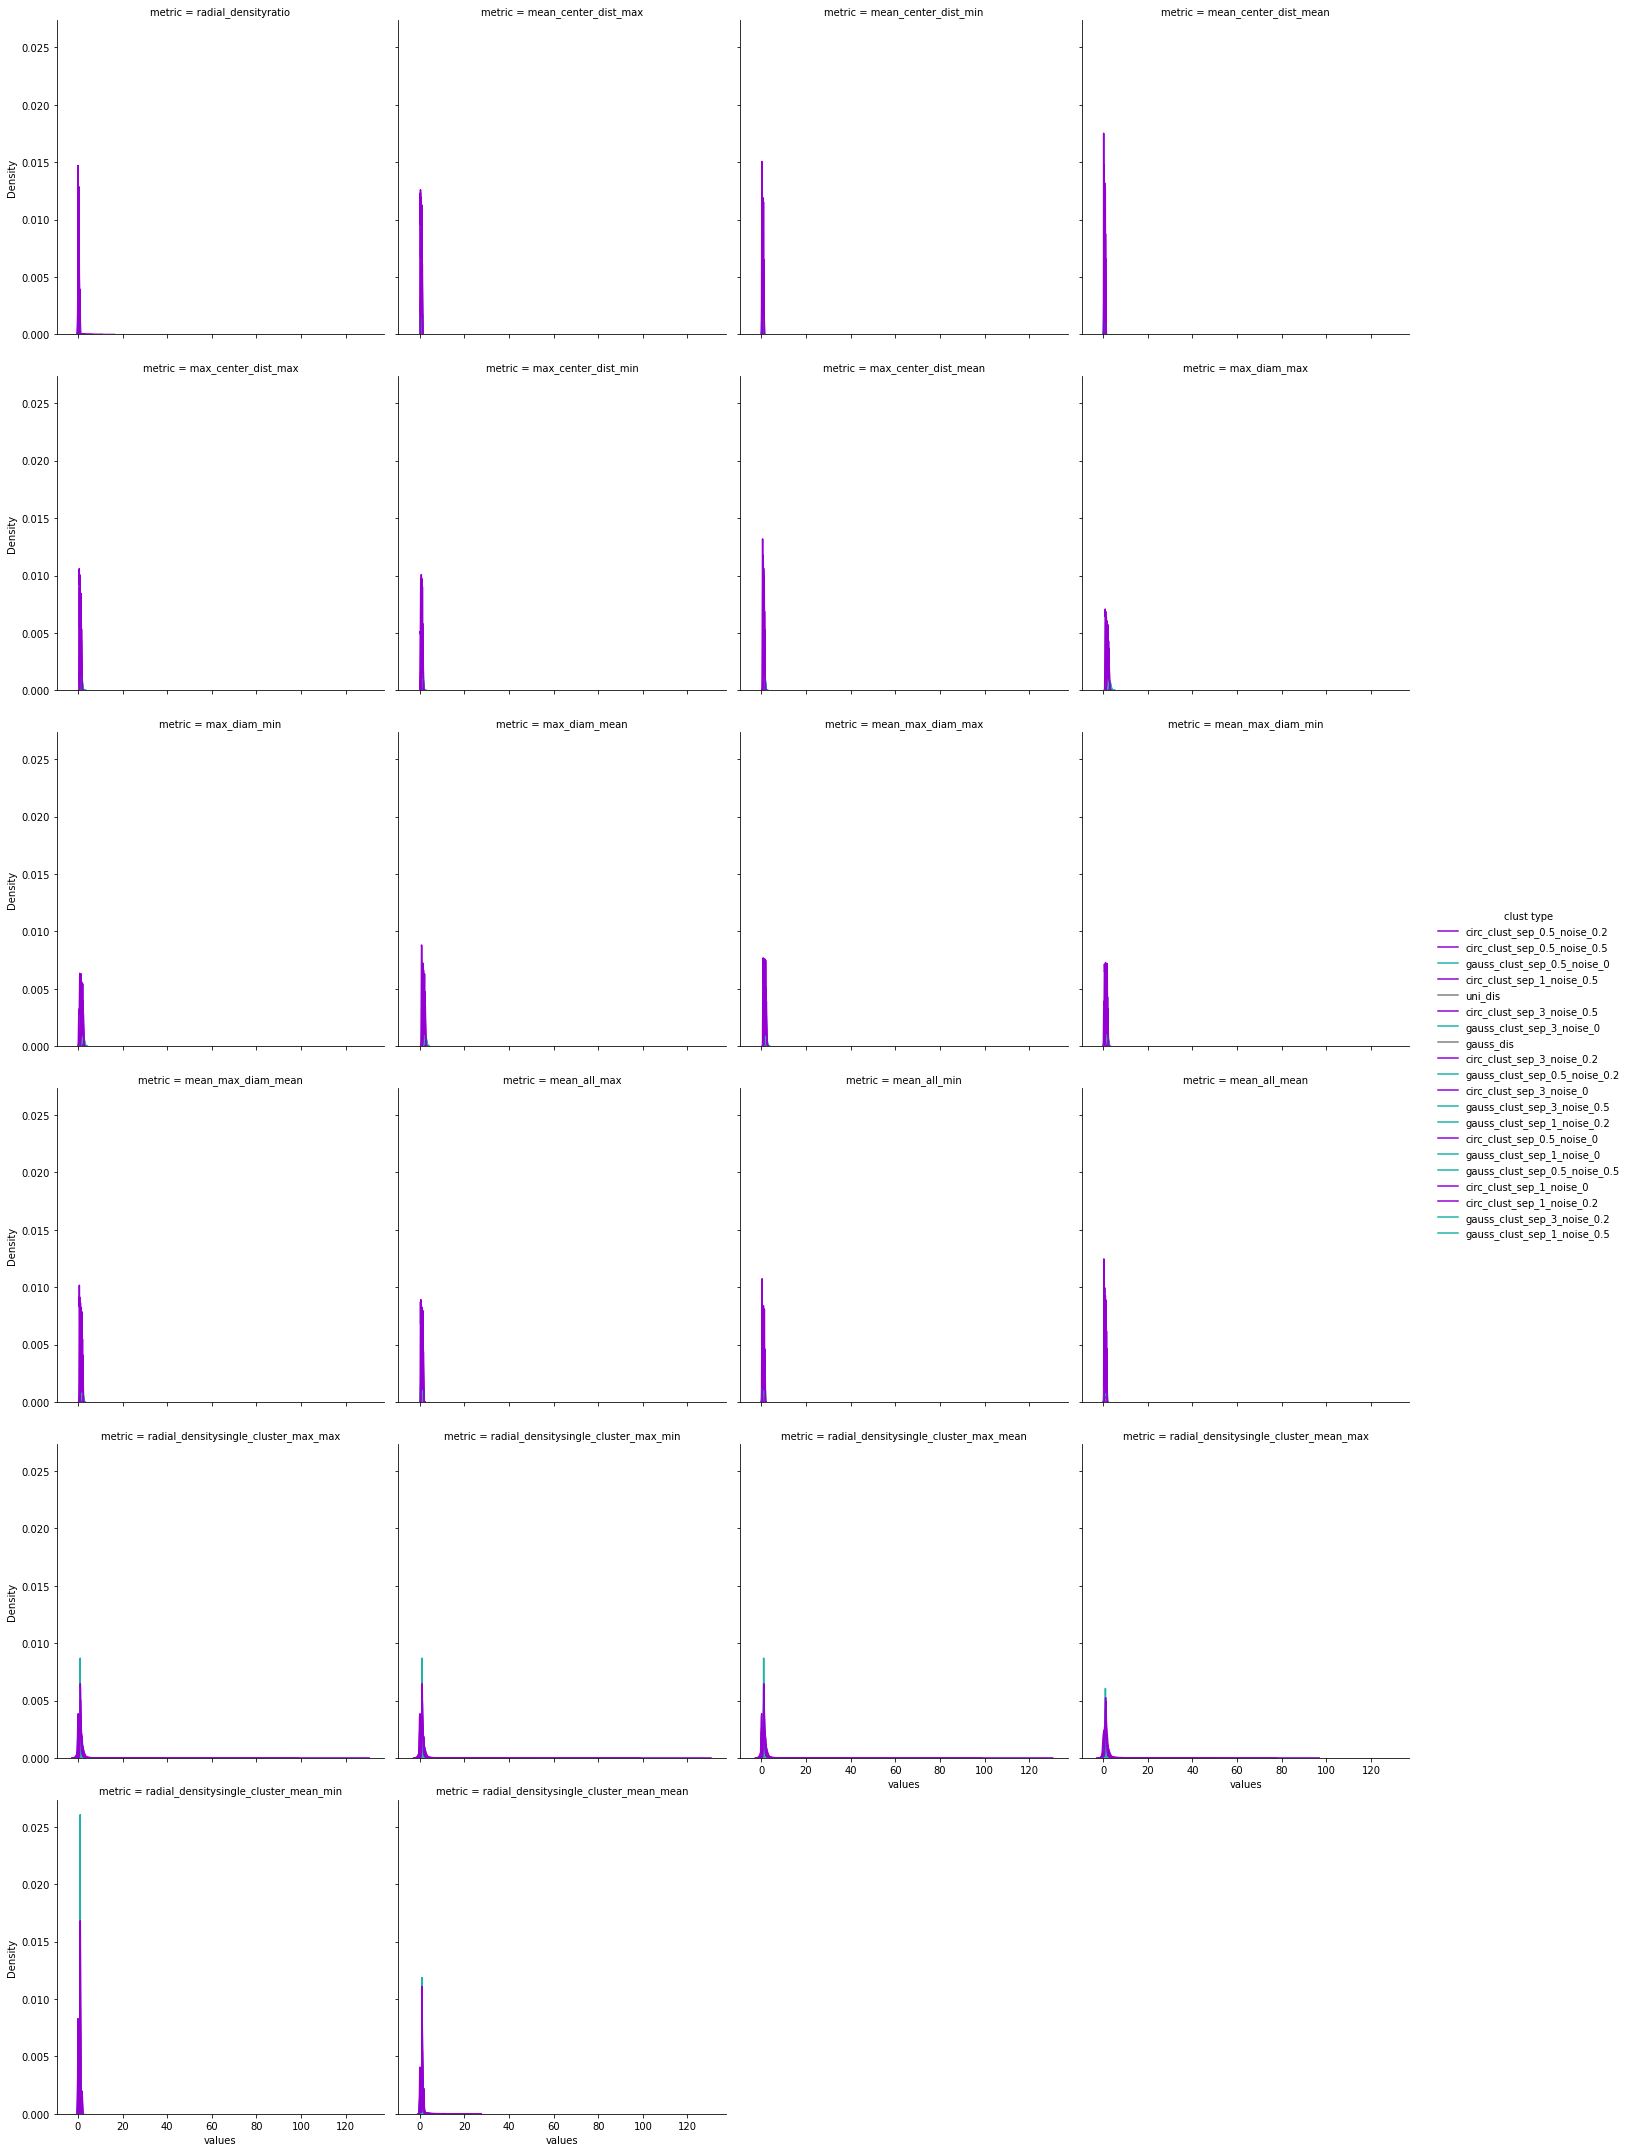

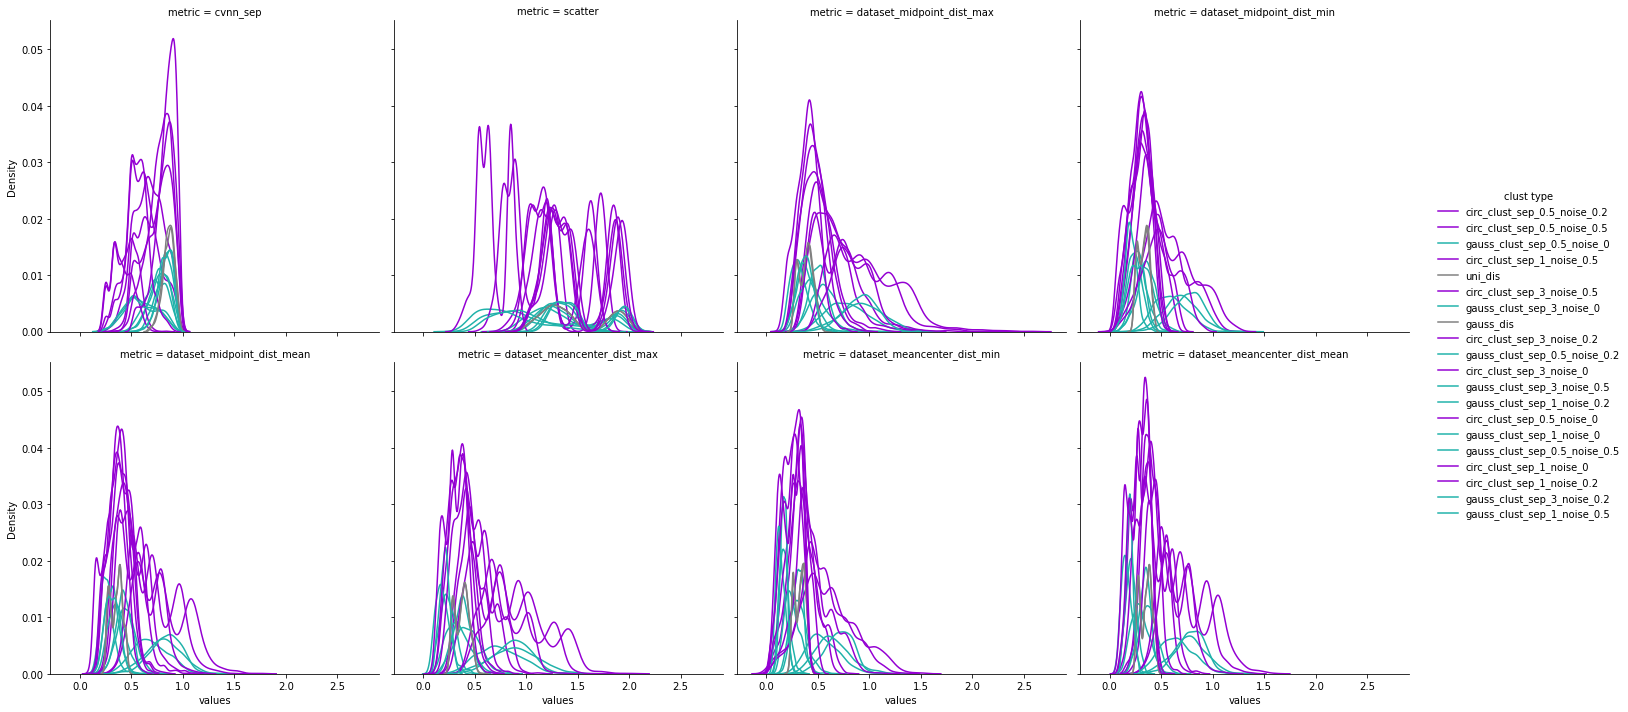

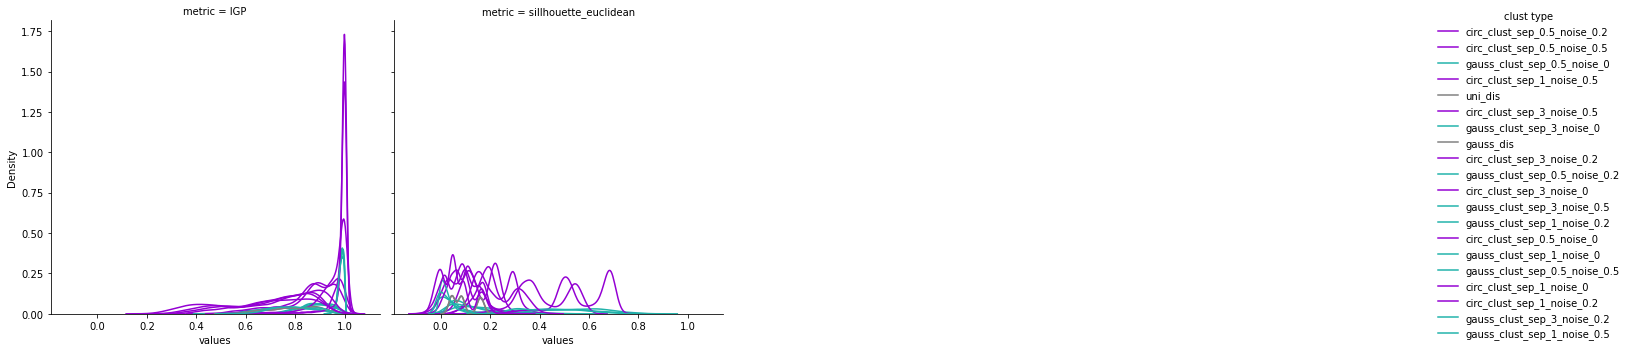

In [45]:
comp_plot = sns.displot(compdf,x = 'values',col = 'metric',hue = 'clust type',kind = 'kde',col_wrap =4,palette=palette)
sep_plot = sns.displot(sepdf,x = 'values',col = 'metric',hue = 'clust type',kind = 'kde',col_wrap =4,palette=palette)
other_plot = sns.displot(otherdf,x = 'values',col = 'metric',hue = 'clust type',kind = 'kde',col_wrap =4,palette=palette)

## Means

In [46]:
comp_means = comp_dict.copy()
sep_means = sep_dict.copy()
other_means = other_dict.copy()

In [47]:
dict_list = [comp_means,sep_means,other_means]
for i in dict_list:
    test_dict = {k + '_' + j:{k2:list_sorter(v2,j) for k2,v2 in v.items() if isinstance(v2[0],list)}for k,v in i.items()for j in ['max','min','mean']}
    i.update(test_dict)
comp_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in comp_means.items() }
sep_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in sep_means.items() }
other_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in other_means.items() }
comp_means = {k:v for k,v in comp_means.items() if len(v) > 0}
sep_means = {k:v for k,v in sep_means.items() if len(v) > 0}
other_means = {k:v for k,v in other_means.items() if len(v) > 0 }

In [48]:
comp_means = {k:{k2:std_mean(v2,v)for k2,v2 in v.items()}  for k,v in comp_means.items()}
sep_means = {k:{k2:std_mean(v2,v) for k2,v2 in v.items()} for k,v in sep_means.items()}
other_means = {k:{k2:std_mean(v2,v) for k2,v2 in v.items()} for k,v in other_means.items()}

comp_dif = {k:mean_dif(v) for k,v in comp_means.items()}
sep_dif = {k:mean_dif(v) for k,v in sep_means.items()}
other_dif = {k:mean_dif(v) for k,v in other_means.items()}
comp_dif = {k:[i for i in v.values()] for k,v in comp_dif.items()}
sep_dif = {k:[i for i in v.values()]  for k,v in sep_dif.items()}
other_dif = {k:[i for i in v.values()] for k,v in other_dif.items()}
comp_dif2 = {k:v for k,v in comp_dif.items() if all(i > 0 for i in v) or all(i < 0 for i in v)} 
sep_dif2 = {k:v for k,v in sep_dif.items() if all(i > 0 for i in v) or all(i < 0 for i in v)} 
other_dif2 = {k:v for k,v in other_dif.items() if all(i > 0 for i in v) or all(i < 0 for i in v)} 
comp_dif2 = {k:min(v) if v[0] > 0 else max(v)for k,v in comp_dif2.items()}
sep_dif = {k:min(v) if v[0] > 0 else max(v) for k,v in sep_dif.items()}

In [49]:
comp_dif = {k:mean_dif(v) for k,v in comp_means.items()}
sep_dif = {k:mean_dif(v) for k,v in sep_means.items()}
other_dif = {k:mean_dif(v) for k,v in other_means.items()}
comp_dif = {k:[i for i in v.values()] for k,v in comp_dif.items()}
sep_dif = {k:[i for i in v.values()]  for k,v in sep_dif.items()}
other_dif = {k:[i for i in v.values()] for k,v in other_dif.items()}

In [50]:
comp_df = {k:res_dict(v) for k,v in comp_dif.items()}
comp_df = pd.DataFrame(comp_df.values())
comp_df['types'] = list(comp_dif.keys())

NameError: name 'comp_df' is not defined

In [51]:
print(comp_df.sort_values(by = 'one_side',ascending = False).head())
print(comp_df.sort_values(by = 'range').head())
print(comp_df.sort_values(by = 'mean',ascending = False).head())

         min       max     range      mean  one_side                  types
14 -0.746084  0.081778  0.827862  0.200396  0.955556           mean_all_min
2  -0.751021  0.082870  0.833891  0.203464  0.953086   mean_center_dist_min
3  -0.659549  0.088450  0.747999  0.180685  0.941975  mean_center_dist_mean
15 -0.655949  0.087495  0.743444  0.177938  0.935802          mean_all_mean
1  -0.577228  0.105855  0.683083  0.133589  0.881481   mean_center_dist_max
         min       max     range      mean  one_side  \
18 -0.010355  0.066960  0.077315  0.001437  0.664198   
17 -0.010355  0.066960  0.077315  0.001437  0.664198   
16 -0.010355  0.066960  0.077315  0.001437  0.664198   
0  -0.028803  0.054175  0.082978  0.002262  0.664198   
19 -0.014871  0.124038  0.138908  0.003064  0.656790   

                                    types  
18  radial_densitysingle_cluster_max_mean  
17   radial_densitysingle_cluster_max_min  
16   radial_densitysingle_cluster_max_max  
0                     radial_de

In [62]:
comp_out = comp_df.sort_values(by = 'mean',ascending = False).reset_index(drop =True).iloc[0:5,]
comp_out.to_csv('data/processed/tables/comp_out.csv')

In [52]:
sep_df = {k:res_dict(v) for k,v in sep_dif.items()}
sep_df = pd.DataFrame(sep_df.values())
sep_df['types'] = list(sep_dif.keys())

In [64]:
sep_out

,min,max,range,mean,one_side,types
0,-0.627706,0.128755,0.756461,0.110534,0.777778,scatter
1,-0.071306,0.449652,0.520959,0.099198,0.881481,dataset_midpoint_dist_max
2,-0.129345,0.493596,0.622940,0.090596,0.797531,dataset_midpoint_dist_mean
3,-0.153745,0.495108,0.648853,0.081838,0.733333,dataset_meancenter_dist_max
4,-0.190332,0.523905,0.714236,0.064626,0.623457,dataset_meancenter_dist_mean


In [63]:
sep_out = sep_df.sort_values(by = 'mean',ascending = False).reset_index(drop =True).iloc[0:5,]
sep_out.to_csv('data/processed/tables/sep_out.csv')

In [53]:
print(sep_df.sort_values(by = 'one_side',ascending = False).head())
print(sep_df.sort_values(by = 'range').head())
print(sep_df.sort_values(by = 'mean',ascending = False).head())

        min       max     range      mean  one_side  \
0 -0.636712  0.174045  0.810757       NaN  0.916049   
2 -0.071306  0.449652  0.520959  0.099198  0.881481   
4 -0.129345  0.493596  0.622940  0.090596  0.797531   
1 -0.627706  0.128755  0.756461  0.110534  0.777778   
5 -0.153745  0.495108  0.648853  0.081838  0.733333   

                         types  
0                     cvnn_sep  
2    dataset_midpoint_dist_max  
4   dataset_midpoint_dist_mean  
1                      scatter  
5  dataset_meancenter_dist_max  
        min       max     range      mean  one_side  \
2 -0.071306  0.449652  0.520959  0.099198  0.881481   
4 -0.129345  0.493596  0.622940  0.090596  0.797531   
5 -0.153745  0.495108  0.648853  0.081838  0.733333   
7 -0.190332  0.523905  0.714236  0.064626  0.623457   
6 -0.192622  0.550472  0.743094  0.027628  0.548148   

                          types  
2     dataset_midpoint_dist_max  
4    dataset_midpoint_dist_mean  
5   dataset_meancenter_dist_max  
7  d

In [54]:
other_df = {k:res_dict(v) for k,v in other_dif.items()}
other_df = pd.DataFrame(other_df.values())
other_df['types'] = list(other_dif.keys())

In [55]:
print(other_df.sort_values(by = 'one_side',ascending = False).head())
print(other_df.sort_values(by = 'range').head())
print(other_df.sort_values(by = 'mean',ascending = False).head())

        min       max     range      mean  one_side                  types
1 -0.208059  0.673616  0.881675  0.122594  0.744444  sillhouette_euclidean
0 -0.738143  0.475897  1.214039  0.065150  0.718519                    IGP
        min       max     range      mean  one_side                  types
1 -0.208059  0.673616  0.881675  0.122594  0.744444  sillhouette_euclidean
0 -0.738143  0.475897  1.214039  0.065150  0.718519                    IGP
        min       max     range      mean  one_side                  types
1 -0.208059  0.673616  0.881675  0.122594  0.744444  sillhouette_euclidean
0 -0.738143  0.475897  1.214039  0.065150  0.718519                    IGP


In [56]:
dict_list = [comp_means,sep_means,other_means]
for i in dict_list:
    test_dict = {k + '_' + j:{k2:list_sorter(v2,j) for k2,v2 in v.items() if isinstance(v2[0],list)}for k,v in i.items()for j in ['max','min','mean']}
    i.update(test_dict)
comp_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in comp_means.items() }
sep_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in sep_means.items() }
other_means = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in other_means.items() }

IndexError: invalid index to scalar variable.

## comp/sep

In [103]:
with open('data/processed/cluster_measures/comp.json') as f:
    comp_dict = json.load(f)
with open('data/processed/cluster_measures/sep.json') as f:
    sep_dict = json.load(f)
with open('data/processed/cluster_measures/other.json') as f:
    other_dict = json.load(f)
comp2 = comp_dict.copy()
sep2 = sep_dict.copy()
other2 = other_dict.copy()
dict_list = [comp2,sep2,other2]
for i in dict_list:
    test_dict = {k + '_' + j:{k2:list_sorter(v2,j) for k2,v2 in v.items() if isinstance(v2[0],list)}for k,v in i.items()for j in ['max','min','mean']}
    i.update(test_dict)
comp2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in comp2.items() }
sep2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in sep2.items() }
other2 = {k:{k2:v2 for k2,v2 in v.items() if isinstance(v2[0],list) == False} for k,v in other2.items() }
comp2 = {k:v for k,v in comp2.items() if len(v) > 0}
sep2 = {k:v for k,v in sep2.items() if len(v) > 0}
other2 = {k:v for k,v in other2.items() if len(v) > 0 }

In [105]:
comp = comp2['mean_center_dist_min']
sep = sep2['dataset_midpoint_dist_max']

In [113]:
res = {
    'comp/sep':{i:[comp[i][j]/sep[i][j] for j in range(len(comp[i]))] for i in comp.keys()},
    'sep/comp':{i:[sep[i][j]/comp[i][j] for j in range(len(comp[i]))] for i in comp.keys()},
    'compXsep':{i:[comp[i][j]*sep[i][j] for j in range(len(comp[i]))] for i in comp.keys()},
    'comp+sep':{i:[comp[i][j]+sep[i][j] for j in range(len(comp[i]))] for i in comp.keys()}
}


In [117]:
res2  = {k:{k2:std_mean(v2,v)for k2,v2 in v.items()}  for k,v in res.items()}
res2 = {k:[i for i in v.values()] for k,v in res2.items()}

In [121]:
res_df = {k:res_dict(v) for k,v in res2.items()}
res_df = pd.DataFrame(res_df.values())

In [124]:
res_df['method'] = list(res2.keys())

In [126]:
res_df.to_csv('data/processed/tables/mult_results.csv')

## testing

In [143]:
test_dict = comp_dif['radial_densityratio']

In [147]:
new_dict = {'zero_count':}

0.6691358024691358

In [101]:
with open('data/processed/cluster_measures/comp.json') as f:
    comp_dict = json.load(f)
with open('data/processed/cluster_measures/sep.json') as f:
    sep_dict = json.load(f)
with open('data/processed/cluster_measures/other.json') as f:
    other_dict = json.load(f)

In [32]:
full_v = other_means['IGP']

In [34]:
min([j for i in full_v.values() for j in i])

0.23